<a href="https://colab.research.google.com/github/ehsan94/Deep-Learning/blob/master/Deutschland_COVID19_SHAP_0to75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Total 91-106

In [1]:
#%pip install shap
#%matplotlib inline
#%pip install catboost

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap

from catboost import Pool, CatBoostRegressor

# Data

In [3]:
df = pd.read_stata('W:\COVID19\std_inz91_106.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [4]:
#df.head()

In [27]:
Y = df['std_inz_91to106']
X = df.loc[:, ~df.columns.isin(['std_inz_91to106', 'eastwest'])]
print("Number of features: ", len(X.columns))

Number of features:  163


# RF model

In [21]:
rfr = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
rf=rfr.fit(X, Y)  

# R2 RF model

In [22]:
rf.score(X, Y)

0.9468061766182394

# CatBoost Model

In [6]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0)
#train the model
cb = model.fit(train_pool)

# prediction
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )
#print(Y.dtype)
preds = preds.reshape(-1, 1)
#print(preds)
from sklearn.linear_model import LinearRegression
from sklearn import metrics
reg = LinearRegression().fit(preds, Y)
print("R2 linReg_model: ", reg.score(preds, Y))
print("RMSE linReg_model: ",metrics.mean_squared_error(preds, Y))

Learning rate set to 0.033171
0:	learn: 71.5764063	total: 158ms	remaining: 2m 38s
1:	learn: 70.6242485	total: 165ms	remaining: 1m 22s
2:	learn: 69.7323829	total: 171ms	remaining: 56.9s
3:	learn: 68.9753810	total: 177ms	remaining: 44.2s
4:	learn: 68.1943953	total: 184ms	remaining: 36.6s
5:	learn: 67.4188768	total: 192ms	remaining: 31.7s
6:	learn: 66.6205921	total: 199ms	remaining: 28.2s
7:	learn: 65.7083575	total: 206ms	remaining: 25.6s
8:	learn: 64.9849102	total: 213ms	remaining: 23.4s
9:	learn: 64.1945452	total: 219ms	remaining: 21.7s
10:	learn: 63.4261220	total: 226ms	remaining: 20.3s
11:	learn: 62.7028575	total: 232ms	remaining: 19.1s
12:	learn: 61.9604028	total: 239ms	remaining: 18.1s
13:	learn: 61.3198010	total: 246ms	remaining: 17.3s
14:	learn: 60.6172527	total: 252ms	remaining: 16.6s
15:	learn: 60.0519085	total: 259ms	remaining: 15.9s
16:	learn: 59.2815249	total: 265ms	remaining: 15.3s
17:	learn: 58.6404510	total: 271ms	remaining: 14.8s
18:	learn: 58.0023763	total: 277ms	remaini

176:	learn: 25.2848770	total: 1.28s	remaining: 5.95s
177:	learn: 25.2261833	total: 1.29s	remaining: 5.94s
178:	learn: 25.1098142	total: 1.29s	remaining: 5.93s
179:	learn: 25.0724980	total: 1.3s	remaining: 5.92s
180:	learn: 25.0325151	total: 1.31s	remaining: 5.92s
181:	learn: 24.9286708	total: 1.31s	remaining: 5.91s
182:	learn: 24.8803072	total: 1.32s	remaining: 5.9s
183:	learn: 24.8531865	total: 1.33s	remaining: 5.89s
184:	learn: 24.6982138	total: 1.33s	remaining: 5.88s
185:	learn: 24.5860867	total: 1.34s	remaining: 5.87s
186:	learn: 24.5547624	total: 1.35s	remaining: 5.86s
187:	learn: 24.5152016	total: 1.35s	remaining: 5.85s
188:	learn: 24.4780502	total: 1.36s	remaining: 5.84s
189:	learn: 24.3749218	total: 1.37s	remaining: 5.83s
190:	learn: 24.2596733	total: 1.37s	remaining: 5.82s
191:	learn: 24.2142315	total: 1.38s	remaining: 5.82s
192:	learn: 24.0788905	total: 1.39s	remaining: 5.81s
193:	learn: 24.0087201	total: 1.4s	remaining: 5.8s
194:	learn: 23.9655536	total: 1.4s	remaining: 5.79

348:	learn: 15.0769435	total: 2.38s	remaining: 4.44s
349:	learn: 15.0490420	total: 2.39s	remaining: 4.43s
350:	learn: 15.0382016	total: 2.39s	remaining: 4.42s
351:	learn: 14.9699680	total: 2.4s	remaining: 4.42s
352:	learn: 14.9121139	total: 2.41s	remaining: 4.41s
353:	learn: 14.9031764	total: 2.41s	remaining: 4.4s
354:	learn: 14.8299645	total: 2.42s	remaining: 4.4s
355:	learn: 14.7417409	total: 2.43s	remaining: 4.39s
356:	learn: 14.6736509	total: 2.43s	remaining: 4.38s
357:	learn: 14.6487828	total: 2.44s	remaining: 4.38s
358:	learn: 14.5605384	total: 2.45s	remaining: 4.37s
359:	learn: 14.4727122	total: 2.45s	remaining: 4.36s
360:	learn: 14.4587564	total: 2.46s	remaining: 4.35s
361:	learn: 14.4512730	total: 2.46s	remaining: 4.34s
362:	learn: 14.4217524	total: 2.47s	remaining: 4.34s
363:	learn: 14.4138032	total: 2.48s	remaining: 4.33s
364:	learn: 14.4054733	total: 2.49s	remaining: 4.33s
365:	learn: 14.3973470	total: 2.49s	remaining: 4.32s
366:	learn: 14.3311621	total: 2.5s	remaining: 4.3

513:	learn: 9.1194090	total: 3.45s	remaining: 3.26s
514:	learn: 9.0928396	total: 3.45s	remaining: 3.25s
515:	learn: 9.0868269	total: 3.46s	remaining: 3.25s
516:	learn: 9.0469544	total: 3.47s	remaining: 3.24s
517:	learn: 9.0097554	total: 3.47s	remaining: 3.23s
518:	learn: 8.9831300	total: 3.48s	remaining: 3.23s
519:	learn: 8.9644425	total: 3.49s	remaining: 3.22s
520:	learn: 8.9304786	total: 3.49s	remaining: 3.21s
521:	learn: 8.8797325	total: 3.5s	remaining: 3.21s
522:	learn: 8.8543520	total: 3.51s	remaining: 3.2s
523:	learn: 8.8451861	total: 3.51s	remaining: 3.19s
524:	learn: 8.8417807	total: 3.52s	remaining: 3.18s
525:	learn: 8.7999303	total: 3.52s	remaining: 3.18s
526:	learn: 8.7799804	total: 3.53s	remaining: 3.17s
527:	learn: 8.7537249	total: 3.54s	remaining: 3.16s
528:	learn: 8.7221569	total: 3.55s	remaining: 3.16s
529:	learn: 8.6894437	total: 3.55s	remaining: 3.15s
530:	learn: 8.6830134	total: 3.56s	remaining: 3.14s
531:	learn: 8.6412405	total: 3.56s	remaining: 3.14s
532:	learn: 8.

679:	learn: 5.2943300	total: 4.54s	remaining: 2.14s
680:	learn: 5.2782591	total: 4.55s	remaining: 2.13s
681:	learn: 5.2544517	total: 4.55s	remaining: 2.12s
682:	learn: 5.2363386	total: 4.56s	remaining: 2.12s
683:	learn: 5.2285887	total: 4.57s	remaining: 2.11s
684:	learn: 5.2163852	total: 4.57s	remaining: 2.1s
685:	learn: 5.1965803	total: 4.58s	remaining: 2.1s
686:	learn: 5.1721280	total: 4.59s	remaining: 2.09s
687:	learn: 5.1542583	total: 4.59s	remaining: 2.08s
688:	learn: 5.1366866	total: 4.6s	remaining: 2.08s
689:	learn: 5.1079182	total: 4.61s	remaining: 2.07s
690:	learn: 5.0907206	total: 4.61s	remaining: 2.06s
691:	learn: 5.0632856	total: 4.62s	remaining: 2.06s
692:	learn: 5.0364593	total: 4.62s	remaining: 2.05s
693:	learn: 5.0188148	total: 4.63s	remaining: 2.04s
694:	learn: 5.0108786	total: 4.63s	remaining: 2.03s
695:	learn: 5.0000003	total: 4.64s	remaining: 2.03s
696:	learn: 4.9773029	total: 4.65s	remaining: 2.02s
697:	learn: 4.9726049	total: 4.65s	remaining: 2.01s
698:	learn: 4.9

852:	learn: 3.1280538	total: 5.62s	remaining: 968ms
853:	learn: 3.1240066	total: 5.63s	remaining: 962ms
854:	learn: 3.1108647	total: 5.63s	remaining: 955ms
855:	learn: 3.1017294	total: 5.64s	remaining: 949ms
856:	learn: 3.0822761	total: 5.64s	remaining: 942ms
857:	learn: 3.0656388	total: 5.65s	remaining: 935ms
858:	learn: 3.0533518	total: 5.66s	remaining: 929ms
859:	learn: 3.0522981	total: 5.66s	remaining: 922ms
860:	learn: 3.0510118	total: 5.67s	remaining: 915ms
861:	learn: 3.0460768	total: 5.67s	remaining: 909ms
862:	learn: 3.0354901	total: 5.68s	remaining: 902ms
863:	learn: 3.0269955	total: 5.69s	remaining: 895ms
864:	learn: 3.0133078	total: 5.69s	remaining: 889ms
865:	learn: 3.0015889	total: 5.7s	remaining: 882ms
866:	learn: 2.9913851	total: 5.71s	remaining: 875ms
867:	learn: 2.9769986	total: 5.71s	remaining: 869ms
868:	learn: 2.9668302	total: 5.72s	remaining: 862ms
869:	learn: 2.9568112	total: 5.72s	remaining: 855ms
870:	learn: 2.9553947	total: 5.73s	remaining: 849ms
871:	learn: 2

# R2 CatBoost

In [7]:
cb.score(X, Y)

0.9992723219281537

# SHAP values 

# RF

In [23]:
shap_values = shap.TreeExplainer(rf).shap_values(X)

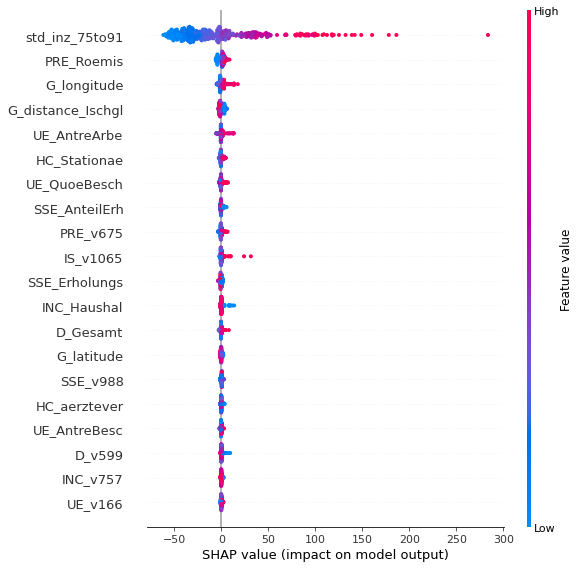

In [24]:
shap.summary_plot(shap_values, X,max_display=20) 

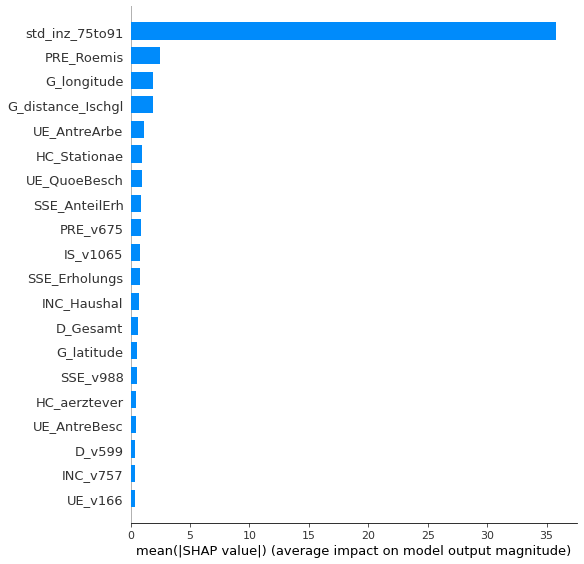

In [25]:
shap.summary_plot(shap_values, X, plot_type="bar",max_display=20)

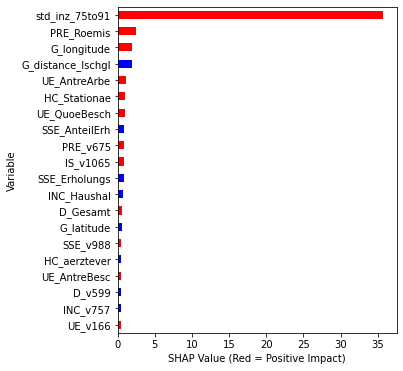

In [26]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2[-20:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X) 

# CatBoost

In [8]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

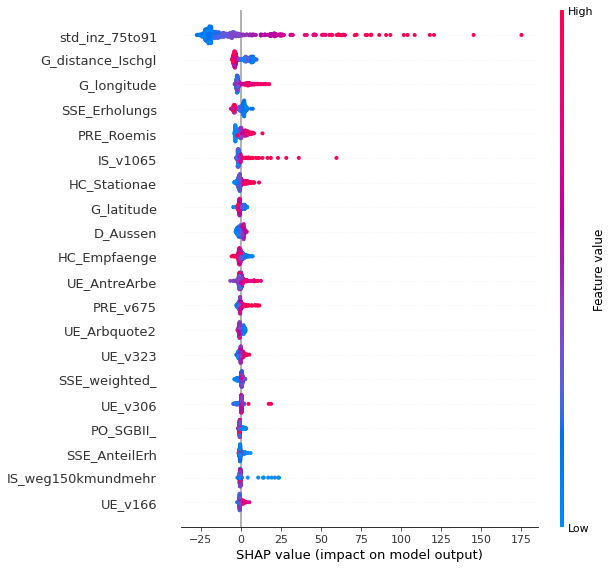

In [9]:
shap.summary_plot(shap_values_cb, X,max_display=20)  #TreeExpliner

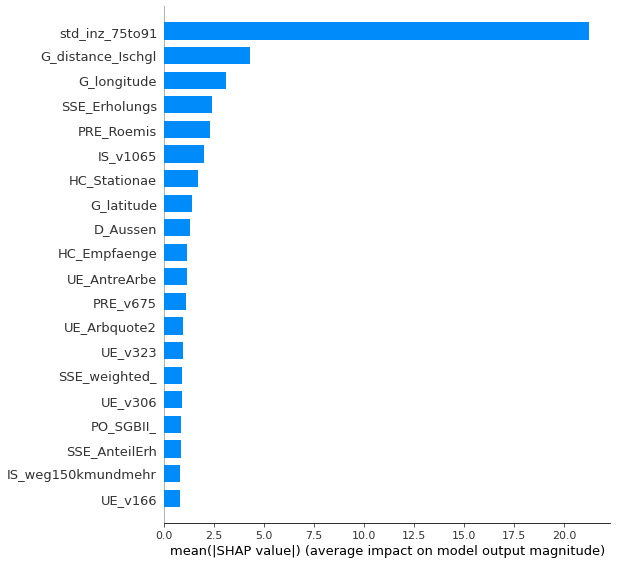

In [10]:
shap.summary_plot(shap_values_cb, X, plot_type="bar",max_display=20)

invalid value encountered in true_divide
invalid value encountered in true_divide


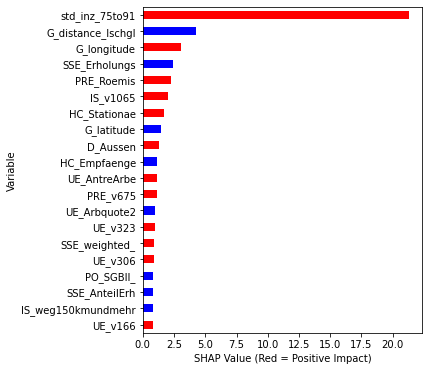

In [11]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2[-20:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

# CatBoost 20 most important vars

In [12]:
f = len(X.columns)
l = f-21
ll = f-11


In [13]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][f:l:-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][f:ll:-1]

X[top20feature].describe()

,std_inz_75to91,G_distance_Ischgl,G_longitude,SSE_Erholungs,PRE_Roemis,IS_v1065,HC_Stationae,G_latitude,D_Aussen,HC_Empfaenge,UE_AntreArbe,PRE_v675,UE_Arbquote2,UE_v323,SSE_weighted_,UE_v306,PO_SGBII_,SSE_AnteilErh,IS_weg150kmundmehr,UE_v166
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,79.461769,431.346405,9.866996,70.509460,32.242809,21.925186,24.358610,50.615292,4.806734,50.857368,9.834411,16.566586,5.356359,27.421446,0.676074,-6.157606,8.995763,2.489026,4.412467,38.296268
std,64.122574,187.236847,2.026269,56.734707,24.361435,15.378859,5.373881,1.740311,6.630641,6.518343,2.016845,5.035090,2.412844,9.129767,0.382720,22.530605,4.146994,2.681488,1.354011,7.717488
min,2.714423,56.052784,6.083333,14.000000,1.700000,0.000000,11.100000,47.500000,-13.900000,28.600000,3.000000,6.900000,1.500000,6.500000,0.143572,-69.900002,2.200000,0.300000,2.000000,15.700000
25%,40.307571,291.752441,8.216666,39.700001,7.900000,13.000000,20.400000,49.283333,1.500000,46.400002,8.600000,13.000000,3.400000,20.299999,0.421747,-14.200000,5.800000,0.800000,3.500000,33.299999
50%,63.813667,420.680756,9.766666,52.799999,29.100000,21.000000,23.700001,50.549999,3.700000,51.099998,10.200000,16.100000,5.000000,27.200001,0.583280,-7.700000,8.500000,1.300000,4.000000,38.599998
75%,99.633545,569.178772,11.416667,76.699997,52.299999,32.000000,27.500000,51.849998,6.000000,55.599998,11.200000,19.700001,6.700000,34.000000,0.811219,-0.800000,11.100000,3.000000,5.200000,43.299999
max,671.134949,866.911194,14.983334,384.600006,87.800003,79.000000,43.299999,54.783333,65.900002,66.699997,14.800000,38.000000,14.000000,54.000000,3.392816,329.000000,23.799999,13.400000,9.100000,68.300003


In [14]:
# initialize Pool
train_pool20 = Pool(data=X[top20feature],
                  label=Y,
                 feature_names = list(X[top20feature].columns))
 

# specify the training parameters 
model20 = CatBoostRegressor(random_seed=0,
                          logging_level="Silent"
                         )
#train the model
cb20 = model20.fit(train_pool20)

In [15]:
# prediction
preds20 = cb20.predict(train_pool20,
                    prediction_type="RawFormulaVal"
                  )
#print(Y.dtype)
preds20 = preds20.reshape(-1, 1)
#print(preds20)
from sklearn.linear_model import LinearRegression
from sklearn import metrics
reg20 = LinearRegression().fit(preds20, Y)
print("R2 linReg_model20: ", reg.score(preds20, Y))
print("RMSE linReg_model20: ",metrics.mean_squared_error(preds20, Y))


R2 linReg_model20:  0.9971414263896471
RMSE linReg_model20:  16.138035293061566


# R2 CatBoost top20

In [16]:
cb20.score(X[top20feature], Y)

0.9969376547845081

# cross validation

In [17]:
# all
import random
iterations = range(0,40)
r2_reg_k_test = list(range(0,40))
rmse_reg_k_test = list(range(0,40))
r2_cb_k_train = list(range(0,40))
r2_cb_k_test = list(range(0,40))
for i in iterations:
    rs = random.sample(range(0,401), 100)
    k_test_x = X.iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X.drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X.columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X.columns))
 
    model = CatBoostRegressor(random_seed=0, logging_level="Silent")
    #train the model
    cb_k = model.fit(train_pool_k)
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    from sklearn.linear_model import LinearRegression
    from sklearn import metrics
    reg_k = LinearRegression().fit(preds_k, k_test_y)
    print(i/len(iterations)*100, "% done; "," R2_reg_test:",reg_k.score(preds_k, k_test_y)) 
    #print("RMSE",metrics.mean_squared_error(preds_k, k_test_y)) 
    #print("R2_cb_train:",cb_k.score(train_pool_k)) 
    #print("R2_cb_test:",cb_k.score(test_pool_k))
    
    r2_reg_k_test[i] = reg_k.score(preds_k, k_test_y)
    rmse_reg_k_test[i] = metrics.mean_squared_error(preds_k, k_test_y)
    r2_cb_k_train[i] = cb_k.score(train_pool_k)
    r2_cb_k_test[i] =  cb_k.score(test_pool_k)

0.0 % done;   R2_reg_test: 0.5982342252963468
2.5 % done;   R2_reg_test: 0.7549919292492843
5.0 % done;   R2_reg_test: 0.6674055557118548
7.5 % done;   R2_reg_test: 0.7038320523489914
10.0 % done;   R2_reg_test: 0.6177602425333812
12.5 % done;   R2_reg_test: 0.6148682415157084
15.0 % done;   R2_reg_test: 0.7080400412666358
17.5 % done;   R2_reg_test: 0.5300408616459922
20.0 % done;   R2_reg_test: 0.6686672552324417
22.5 % done;   R2_reg_test: 0.7638838611334186
25.0 % done;   R2_reg_test: 0.6811976919176611
27.500000000000004 % done;   R2_reg_test: 0.5407180280808236
30.0 % done;   R2_reg_test: 0.6224406080844441
32.5 % done;   R2_reg_test: 0.5737313531240918
35.0 % done;   R2_reg_test: 0.559600154726138
37.5 % done;   R2_reg_test: 0.46032658565197027
40.0 % done;   R2_reg_test: 0.5052482409279417
42.5 % done;   R2_reg_test: 0.7487199282581227
45.0 % done;   R2_reg_test: 0.5839345310319921
47.5 % done;   R2_reg_test: 0.6428343433427159
50.0 % done;   R2_reg_test: 0.6474765045012141
52.

In [18]:
print("Mean R2 of linReg_modesl: ", sum(r2_reg_k_test)/len(r2_reg_k_test))
print("Mean R2 of CatBoost_models:",sum(r2_cb_k_train)/len(r2_cb_k_train))

Mean R2 of linReg_modesl:  0.6194840465702544
Mean R2 of CatBoost_models: 0.999770590755306


In [19]:
import random
iterations = range(0,40)
r2_reg_k_test = list(range(0,40))
rmse_reg_k_test = list(range(0,40))
r2_cb_k_train = list(range(0,40))
r2_cb_k_test = list(range(0,40))
for i in iterations:
    rs = random.sample(range(0,401), 100)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))
 
    model = CatBoostRegressor(random_seed=0, logging_level="Silent")
    #train the model
    cb_k = model.fit(train_pool_k)
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    from sklearn.linear_model import LinearRegression
    from sklearn import metrics
    reg_k = LinearRegression().fit(preds_k, k_test_y)
    print(i/len(iterations)*100, "% done; "," R2_reg_test:",reg_k.score(preds_k, k_test_y)) 
    #print("RMSE",metrics.mean_squared_error(preds_k, k_test_y)) 
    #print("R2_cb_train:",cb_k.score(train_pool_k)) 
    #print("R2_cb_test:",cb_k.score(test_pool_k))
    
    r2_reg_k_test[i] = reg_k.score(preds_k, k_test_y)
    rmse_reg_k_test[i] = metrics.mean_squared_error(preds_k, k_test_y)
    r2_cb_k_train[i] = cb_k.score(train_pool_k)
    r2_cb_k_test[i] =  cb_k.score(test_pool_k)

0.0 % done;   R2_reg_test: 0.7631755037865684
2.5 % done;   R2_reg_test: 0.7512632671108355
5.0 % done;   R2_reg_test: 0.6632296833689784
7.5 % done;   R2_reg_test: 0.7601052708689848
10.0 % done;   R2_reg_test: 0.7536635842124535
12.5 % done;   R2_reg_test: 0.7397682271842665
15.0 % done;   R2_reg_test: 0.7052086021426317
17.5 % done;   R2_reg_test: 0.6432276743646229
20.0 % done;   R2_reg_test: 0.7125410839841297
22.5 % done;   R2_reg_test: 0.6327458649650295
25.0 % done;   R2_reg_test: 0.4880737201983454
27.500000000000004 % done;   R2_reg_test: 0.7016941486243702
30.0 % done;   R2_reg_test: 0.5206535887416791
32.5 % done;   R2_reg_test: 0.6209485974703932
35.0 % done;   R2_reg_test: 0.6802793386616581
37.5 % done;   R2_reg_test: 0.6845333579148701
40.0 % done;   R2_reg_test: 0.7299408833890908
42.5 % done;   R2_reg_test: 0.5925223718293608
45.0 % done;   R2_reg_test: 0.675205905869686
47.5 % done;   R2_reg_test: 0.741994220331299
50.0 % done;   R2_reg_test: 0.6913891708349322
52.5 

In [20]:
print("Mean R2 of linReg_modesl: ", sum(r2_reg_k_test)/len(r2_reg_k_test))
print("Mean R2 of CatBoost_models:",sum(r2_cb_k_train)/len(r2_cb_k_train))

Mean R2 of linReg_modesl:  0.6683631221594803
Mean R2 of CatBoost_models: 0.9980228267687886
